In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d balraj98/horse2zebra-dataset
!unzip horse2zebra-dataset.zip -d horse2zebra_dataset

 98% 109M/111M [00:05<00:00, 23.2MB/s]
100% 111M/111M [00:05<00:00, 19.8MB/s]
Archive:  horse2zebra-dataset.zip
  inflating: horse2zebra_dataset/metadata.csv  
  inflating: horse2zebra_dataset/testA/n02381460_1000.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1010.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1030.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1090.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1100.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1110.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1120.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1160.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_120.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1210.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1260.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1300.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1350.jpg  
  inflating: horse2zebra_dataset/testA/n02381460_1360.jpg  
 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from PIL import Image
from torch.utils.data import Dataset
import torchvision.utils as vutils
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

In [ ]:
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

root_zebra = "/content/horse2zebra_dataset/trainB"
root_horse = "/content/horse2zebra_dataset/trainA"

batch_size = 8

dataset = HorseZebraDataset(root_zebra, root_horse, transform=transforms)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
root_zebra_test = "/content/horse2zebra_dataset/testB"
root_horse_test = "/content/horse2zebra_dataset/testA"
test_dataset = HorseZebraDataset(root_zebra_test, root_horse_test, transform=transforms)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

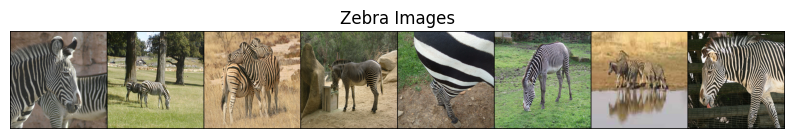

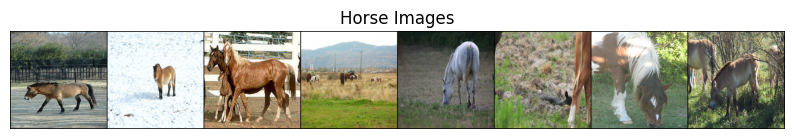

In [ ]:
data_iter = iter(train_loader)
zebra_images, horse_images = next(data_iter)

def show_images(images, title):
    plt.figure(figsize=(10, 5))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images[:8], padding=2, normalize=True), (1, 2, 0)))
    plt.show()

show_images(zebra_images, title="Zebra Images")
show_images(horse_images, title="Horse Images")

# **1st**

In [ ]:
# CycleGAN model
class CycleGAN(nn.Module):
    def __init__(self, G_XtoY, G_YtoX, D_X, D_Y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.G_XtoY = G_XtoY
        self.G_YtoX = G_YtoX
        self.D_X = D_X
        self.D_Y = D_Y
        self.lambda_cycle = lambda_cycle

    def forward(self, real_X, real_Y):
        fake_Y = self.G_XtoY(real_X)
        cycle_X = self.G_YtoX(fake_Y)
        fake_X = self.G_YtoX(real_Y)
        cycle_Y = self.G_XtoY(fake_X)

        loss_G = (
            torch.mean((self.D_Y(fake_Y) - 1) ** 2) +
            torch.mean((self.D_X(fake_X) - 1) ** 2) +
            self.lambda_cycle * (torch.mean((cycle_X - real_X) ** 2) + torch.mean((cycle_Y - real_Y) ** 2))
        )

        return fake_X, fake_Y, cycle_X, cycle_Y, loss_G

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma * out + x
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)
#Generator
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.self_attention = SelfAttention(num_features*4)
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        x = self.self_attention(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

if __name__ == "__main__":
    test()

class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 2):
        super(CNNBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,bias=True,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

#Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2, inplace=True)
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels, out_channels=feature, stride=1 if feature == features[-1] else 2))
            layers.append(SelfAttention(feature))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

G_XtoY = Generator(img_channels=3, num_residuals=9)
G_YtoX = Generator(img_channels=3, num_residuals=9)
D_X = Discriminator(in_channels=3)
D_Y = Discriminator(in_channels=3)

cycle_gan = CycleGAN(G_XtoY, G_YtoX, D_X, D_Y)

# Optimizers
optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle_gan = cycle_gan.to(device)
D_X = D_X.to(device)
D_Y = D_Y.to(device)

torch.Size([2, 3, 256, 256])
torch.Size([5, 1, 30, 30])


In [ ]:
# Loss function
criterion = nn.BCELoss()

# Training
num_epochs = 10
lambda_cycle = 10

for epoch in range(num_epochs):
    for batch_idx, (real_horse, real_zebra) in enumerate(train_loader):
        real_horse = real_horse.to(device)
        real_zebra = real_zebra.to(device)

        optimizer_G.zero_grad()

        fake_zebra, fake_horse, reconstructed_horse, reconstructed_zebra, loss_G = cycle_gan(real_horse, real_zebra)

        loss_G.backward()
        optimizer_G.step()

        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()

        pred_real_horse = D_X(real_horse)
        loss_D_X_real = criterion(pred_real_horse, torch.ones_like(pred_real_horse))
        pred_fake_horse = D_X(fake_horse.detach())
        loss_D_X_fake = criterion(pred_fake_horse, torch.zeros_like(pred_fake_horse))
        loss_D_X = (loss_D_X_real + loss_D_X_fake) / 2

        loss_D_X.backward()
        optimizer_D_X.step()

        pred_real_zebra = D_Y(real_zebra)
        loss_D_Y_real = criterion(pred_real_zebra, torch.ones_like(pred_real_zebra))
        pred_fake_zebra = D_Y(fake_zebra.detach())
        loss_D_Y_fake = criterion(pred_fake_zebra, torch.zeros_like(pred_fake_zebra))
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) / 2

        loss_D_Y.backward()
        optimizer_D_Y.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss_D_X: {loss_D_X.item()}, Loss_D_Y: {loss_D_Y.item()}, Loss_G: {loss_G.item()}")

    print("Epoch completed!")

# **2nd**

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512], num_classes=2):
        super(Discriminator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layers = nn.ModuleList()
        in_channels = features[0]
        for feature in features[1:]:
            self.layers.append(CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature

        self.domain_classifier = nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')

        self.aux_classifier = nn.Conv2d(in_channels, num_classes, kernel_size=4, stride=1, padding=1, padding_mode='reflect')

    def forward(self, x):
        x = self.initial(x)
        for layer in self.layers:
            x = layer(x)
        domain_output = torch.sigmoid(self.domain_classifier(x))
        class_output = self.aux_classifier(x).squeeze()
        return domain_output, class_output

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                CNNBlock(num_features, num_features * 2, stride=2),
                CNNBlock(num_features * 2, num_features * 4, stride=2),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.ConvTranspose2d(num_features * 4, num_features * 2, kernel_size=4, stride=2, padding=1),
                    nn.InstanceNorm2d(num_features * 2),
                    nn.ReLU(inplace=True),
                ),
                nn.Sequential(
                    nn.ConvTranspose2d(num_features * 2, num_features, kernel_size=4, stride=2, padding=1),
                    nn.InstanceNorm2d(num_features),
                    nn.ReLU(inplace=True),
                ),
            ]
        )
        self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

class SemiSupervisedCycleGAN(nn.Module):
    def __init__(self, G_XtoY, G_YtoX, D_X, D_Y, lambda_cycle=10, lambda_cls=1):
        super(SemiSupervisedCycleGAN, self).__init__()
        self.G_XtoY = G_XtoY
        self.G_YtoX = G_YtoX
        self.D_X = D_X
        self.D_Y = D_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_cls = lambda_cls

    def forward(self, real_X, real_Y, labels_X=None, labels_Y=None):
        fake_Y = self.G_XtoY(real_X)
        cycle_X = self.G_YtoX(fake_Y)
        fake_X = self.G_YtoX(real_Y)
        cycle_Y = self.G_XtoY(fake_X)

        # Adversarial loss for fake images
        loss_G = (
            torch.mean((self.D_Y(fake_Y)[0] - 1) ** 2) +
            torch.mean((self.D_X(fake_X)[0] - 1) ** 2) +
            self.lambda_cycle * (torch.mean((cycle_X - real_X) ** 2) + torch.mean((cycle_Y - real_Y) ** 2))
        )

        # Semi-supervised loss for discriminator
        if labels_X is not None:
            domain_loss_X, class_loss_X = self.calculate_discriminator_loss(self.D_X, real_X, labels_X)
            loss_G += self.lambda_cls * (domain_loss_X + class_loss_X)
        if labels_Y is not None:
            domain_loss_Y, class_loss_Y = self.calculate_discriminator_loss(self.D_Y, real_Y, labels_Y)
            loss_G += self.lambda_cls * (domain_loss_Y + class_loss_Y)

        return fake_X, fake_Y, cycle_X, cycle_Y, loss_G

    def calculate_discriminator_loss(self, discriminator, real_images, labels):
        domain_output, class_output = discriminator(real_images)
        domain_loss = F.binary_cross_entropy(domain_output, torch.ones_like(domain_output))
        class_loss = F.cross_entropy(class_output, labels)
        return domain_loss, class_loss

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

def test_discriminator():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds[0].shape, preds[1].shape)

if __name__ == "__main__":
    test()
    test_discriminator()

G_XtoY = Generator(img_channels=3, num_residuals=9)
G_YtoX = Generator(img_channels=3, num_residuals=9)
D_X = Discriminator(in_channels=3)
D_Y = Discriminator(in_channels=3)

cycle_gan = SemiSupervisedCycleGAN(G_XtoY, G_YtoX, D_X, D_Y)

optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# **3rd**

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

if __name__ == "__main__":
    test()

class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 2):
        super(CNNBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,bias=True,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels = 3,features = [64,128,256,512]):
        super(Discriminator,self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,out_channels=features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2,inplace=True)
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels,out_channels=feature,stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect'))
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

class CycleGAN(nn.Module):
    def __init__(self, G_XtoY, G_YtoX, D_X, D_Y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.G_XtoY = G_XtoY
        self.G_YtoX = G_YtoX
        self.D_X = D_X
        self.D_Y = D_Y
        self.lambda_cycle = lambda_cycle

    def forward(self, real_X, real_Y):
        fake_Y = self.G_XtoY(real_X)
        cycle_X = self.G_YtoX(fake_Y)
        fake_X = self.G_YtoX(real_Y)
        cycle_Y = self.G_XtoY(fake_X)

        loss_G = (
            torch.mean((self.D_Y(fake_Y) - 1) ** 2) +
            torch.mean((self.D_X(fake_X) - 1) ** 2) +
            self.lambda_cycle * (torch.mean((cycle_X - real_X) ** 2) + torch.mean((cycle_Y - real_Y) ** 2))
        )

        return fake_X, fake_Y, cycle_X, cycle_Y, loss_G

G_XtoY = Generator(img_channels=3, num_residuals=9)
G_YtoX = Generator(img_channels=3, num_residuals=9)
D_X = Discriminator(in_channels=3)
D_Y = Discriminator(in_channels=3)

cycle_gan = CycleGAN(G_XtoY, G_YtoX, D_X, D_Y)

optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

torch.Size([2, 3, 256, 256])
torch.Size([5, 1, 30, 30])


Epoch [1/1], Batch [1/167], Loss_D_X: 0.7317643761634827, Loss_D_Y: 0.708598792552948, Loss_G: 7.393832206726074
Epoch [1/1], Batch [2/167], Loss_D_X: 0.9210652709007263, Loss_D_Y: 0.8447198867797852, Loss_G: 5.89801025390625
Epoch [1/1], Batch [3/167], Loss_D_X: 0.7607404589653015, Loss_D_Y: 0.6952111721038818, Loss_G: 7.659320831298828
Epoch [1/1], Batch [4/167], Loss_D_X: 0.7432878017425537, Loss_D_Y: 0.800690770149231, Loss_G: 7.010870933532715
Epoch [1/1], Batch [5/167], Loss_D_X: 0.7005822658538818, Loss_D_Y: 0.8484055995941162, Loss_G: 6.201660633087158
Epoch [1/1], Batch [6/167], Loss_D_X: 0.6872857213020325, Loss_D_Y: 0.6941620111465454, Loss_G: 5.418172836303711
Epoch [1/1], Batch [7/167], Loss_D_X: 0.6894022822380066, Loss_D_Y: 0.7164064049720764, Loss_G: 3.6126911640167236
Epoch [1/1], Batch [8/167], Loss_D_X: 0.6882022023200989, Loss_D_Y: 0.6932224035263062, Loss_G: 5.078559875488281
Epoch [1/1], Batch [9/167], Loss_D_X: 0.6799575090408325, Loss_D_Y: 0.6899881362915039, Lo

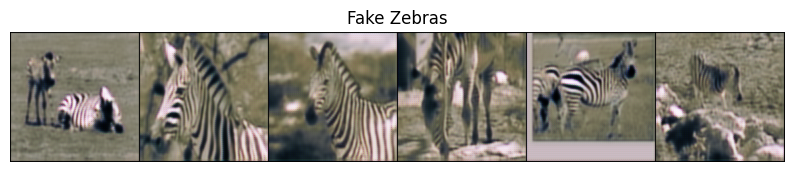

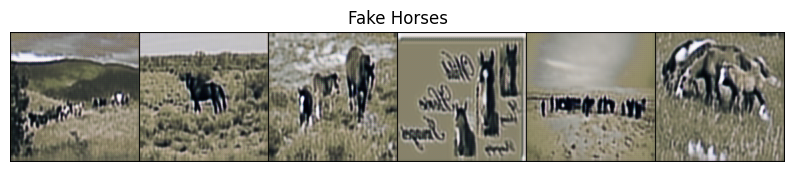

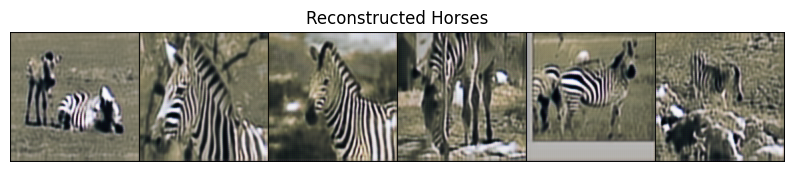

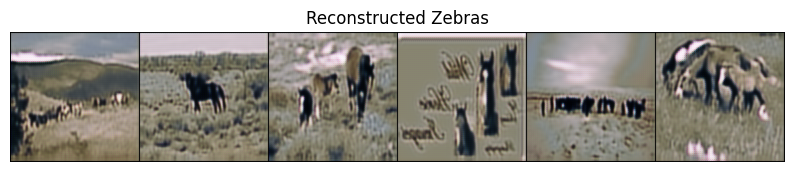

In [ ]:
# Adversarial attack function using FGSM
epsilon = 0.05
alpha = 0.01
num_epochs = 1

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

for epoch in range(num_epochs):
    for batch_idx, (real_horse, real_zebra) in enumerate(train_loader):
        real_horse = real_horse.to(device)
        real_zebra = real_zebra.to(device)

        optimizer_G.zero_grad()
        fake_zebra, fake_horse, reconstructed_horse, reconstructed_zebra, loss_G = cycle_gan(real_horse, real_zebra)

        loss_G.backward()
        optimizer_G.step()

        optimizer_D_X.zero_grad()
        optimizer_D_Y.zero_grad()

        perturbed_real_horse = fgsm_attack(real_horse, epsilon, torch.randn_like(real_horse).requires_grad_(True))

        pred_real_horse = D_X(real_horse)
        pred_perturbed_real_horse = D_X(perturbed_real_horse)
        loss_D_X_real = criterion(pred_real_horse, torch.ones_like(pred_real_horse))
        loss_D_X_perturbed_real = criterion(pred_perturbed_real_horse, torch.zeros_like(pred_perturbed_real_horse))

        loss_D_X = (loss_D_X_real + loss_D_X_perturbed_real) / 2
        loss_D_X.backward()
        optimizer_D_X.step()

        perturbed_real_zebra = fgsm_attack(real_zebra, epsilon, torch.randn_like(real_zebra).requires_grad_(True))

        pred_real_zebra = D_Y(real_zebra)
        pred_perturbed_real_zebra = D_Y(perturbed_real_zebra)
        loss_D_Y_real = criterion(pred_real_zebra, torch.ones_like(pred_real_zebra))
        loss_D_Y_perturbed_real = criterion(pred_perturbed_real_zebra, torch.zeros_like(pred_perturbed_real_zebra))

        loss_D_Y = (loss_D_Y_real + loss_D_Y_perturbed_real) / 2
        loss_D_Y.backward()
        optimizer_D_Y.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss_D_X: {loss_D_X.item()}, Loss_D_Y: {loss_D_Y.item()}, Loss_G: {loss_G.item()}")

    print("Epoch completed!")

cycle_gan.eval()

fake_zebra = cycle_gan.G_XtoY(real_horse.to(device))
fake_horse = cycle_gan.G_YtoX(real_zebra.to(device))

fake_zebra = fake_zebra.cpu()
fake_horse = fake_horse.cpu()

reconstructed_horse = cycle_gan.G_YtoX(fake_zebra.to(device))
reconstructed_zebra = cycle_gan.G_XtoY(fake_horse.to(device))

reconstructed_horse = reconstructed_horse.cpu()
reconstructed_zebra = reconstructed_zebra.cpu()

show_images(fake_zebra, title="Fake Zebras")
show_images(fake_horse, title="Fake Horses")
show_images(reconstructed_horse, title="Reconstructed Horses")
show_images(reconstructed_zebra, title="Reconstructed Zebras")